In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid

from helpers import plot_losses

## RCV dataset from ChocoSGD Paper

In [11]:
def run_logistic(A, y, param):
    m = DecentralizedSGDLogistic(param)
    res = m.fit(A, y)
    print('{} - score: {}'.format(param, m.score(A, y)))
    return res, m

### Load dataset

In [3]:
dataset_path = os.path.expanduser('../ChocoSGD/data/rcv1_test.binary.bz2')
print('Loading dataset...')
A, y = load_svmlight_file(dataset_path)
A_p = A[:100000]
y_p = y[:100000]
y_p = 1*(y_p > 0)

Loading dataset...


### Compute the baseline with SGD

In [5]:
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A_p.shape[0])
clf.fit(A_p, y_p)
print(clf.score(A_p, y_p))
x_predict = clf.predict(A_p)
exact_optimum = log_loss(x_predict, y_p) + (1 / A_p.shape[0]) * np.sum(x_predict**2)

/home/adirlou/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.97885


### Compute with Decentralized SGD

In [ ]:
reg = 1 / A_p.shape[0]
n_features = A_p.shape[1]

params_disconnected = Parameters(num_epoch=5, lr_type='bottou',
                           initial_lr=10, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=128,
                           method='plain',topology='complete', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive')

res_disconnected, dec_log = run_logistic(A_p, y_p, params_disconnected)

"""params_ring = dict(name="chocosgd-centralized", num_epoch=5, lr_type='bottou',
                           initial_lr=0.2, tau=n_features, regularizer=reg,
                           quantization='full', n_cores=10,
                           method='plain', topology='centralized', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive')

res_centralized = run_logistic(A_p, y_p, params_ring)"""


## Higgs Boson Dataset

In [23]:
def run_logistic(A, y, param):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y)
    print('{} - score: {}'.format(param, m.score(A, y)))
    return list_losses

In [24]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [25]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [26]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load dataset

In [27]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [28]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.747132
Final loss: 0.505799416943578


### Computing with Decentralized SGD

In [75]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 30

params_disconnected = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=512,
                           method='plain', topology='complete', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every)

params_complete = params_disconnected.copy()

losses_complete = run_logistic(A, y, params_complete)

length of indices: 512
length of last machine indices: 488
current iteration: 0 epoch: 0 epoch_iteration 0 loss 1.5920398503931399 elapsed 0.02684617042541504s
current iteration: 30 epoch: 0 epoch_iteration 30 loss 1.2656548868139803 elapsed 0.8059828281402588s
current iteration: 60 epoch: 0 epoch_iteration 60 loss 1.0484439654146755 elapsed 1.5671215057373047s
current iteration: 90 epoch: 0 epoch_iteration 90 loss 0.9026857104556367 elapsed 2.320585250854492s
current iteration: 120 epoch: 0 epoch_iteration 120 loss 0.7998419267397896 elapsed 3.0820844173431396s
current iteration: 150 epoch: 0 epoch_iteration 150 loss 0.7304380399716018 elapsed 3.8499443531036377s
current iteration: 180 epoch: 0 epoch_iteration 180 loss 0.6858879834675914 elapsed 4.604231119155884s
current iteration: 210 epoch: 0 epoch_iteration 210 loss 0.6526703722909616 elapsed 5.34389853477478s
current iteration: 240 epoch: 0 epoch_iteration 240 loss 0.6297029676410937 elapsed 6.0893590450286865s
current iteration:

### Barbell and Path topologies

In [76]:
params_barbell = params_disconnected.copy()
params_barbell['topology'] = 'barbell'
losses_barbell = run_logistic(A, y, params_barbell)

length of indices: 512
length of last machine indices: 488
current iteration: 0 epoch: 0 epoch_iteration 0 loss 1.7971129396432846 elapsed 0.027198076248168945s
current iteration: 30 epoch: 0 epoch_iteration 30 loss 1.3166894336883561 elapsed 0.7927143573760986s
current iteration: 60 epoch: 0 epoch_iteration 60 loss 1.0537606827052988 elapsed 1.5613818168640137s
current iteration: 90 epoch: 0 epoch_iteration 90 loss 0.8974830871795015 elapsed 2.3299202919006348s
current iteration: 120 epoch: 0 epoch_iteration 120 loss 0.7998170787861831 elapsed 3.10394287109375s
current iteration: 150 epoch: 0 epoch_iteration 150 loss 0.7305780444393379 elapsed 3.8519654273986816s
current iteration: 180 epoch: 0 epoch_iteration 180 loss 0.678957064429257 elapsed 4.610030174255371s
current iteration: 210 epoch: 0 epoch_iteration 210 loss 0.6440390177235721 elapsed 5.3663170337677s
current iteration: 240 epoch: 0 epoch_iteration 240 loss 0.6195763109361624 elapsed 6.11906886100769s
current iteration: 270

In [77]:
params_path = params_disconnected.copy()
params_path['topology'] = 'path'
losses_path = run_logistic(A, y, params_path)

length of indices: 512
length of last machine indices: 488
current iteration: 0 epoch: 0 epoch_iteration 0 loss 2.273379955171478 elapsed 0.027978181838989258s
current iteration: 30 epoch: 0 epoch_iteration 30 loss 1.510775650633685 elapsed 0.8049638271331787s
current iteration: 60 epoch: 0 epoch_iteration 60 loss 1.0754757014351857 elapsed 1.5895848274230957s
current iteration: 90 epoch: 0 epoch_iteration 90 loss 0.8683361363867258 elapsed 2.3527257442474365s
current iteration: 120 epoch: 0 epoch_iteration 120 loss 0.7740928672589413 elapsed 3.1077940464019775s
current iteration: 150 epoch: 0 epoch_iteration 150 loss 0.7172132378184558 elapsed 3.8638858795166016s
current iteration: 180 epoch: 0 epoch_iteration 180 loss 0.68174610965828 elapsed 4.617648124694824s
current iteration: 210 epoch: 0 epoch_iteration 210 loss 0.6569797896835075 elapsed 5.365100860595703s
current iteration: 240 epoch: 0 epoch_iteration 240 loss 0.6390053769700381 elapsed 6.118823289871216s
current iteration: 2

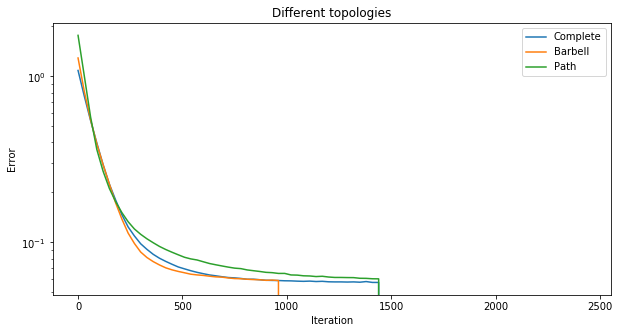

In [80]:
iterations_indices = np.arange(0, losses_complete.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete, losses_barbell, losses_path)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Barbell", "Path"], title="Different topologies")